In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [4]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [6]:
def deprocess(x):
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

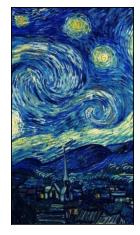

In [51]:
img = load_and_process_image('style1.jpg')
display_image(img)

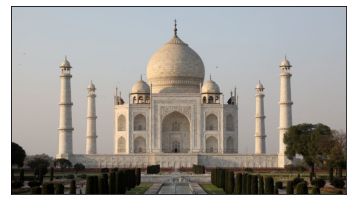

In [52]:
img = load_and_process_image('content1.jpg')
display_image(img)

In [53]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]

In [54]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [55]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

In [56]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

In [79]:
import time

generated_images = []

def training_loop(content_path, style_path, iterations = 50, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = Adam(learning_rate = 8.,amsgrad=True)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [80]:
final = training_loop('content1.jpg','style1.jpg')

Cost at 0: 9416443904.0. Time elapsed: 0.9825778007507324
Cost at 5: 1534843904.0. Time elapsed: 5.825538635253906
Cost at 10: 898848896.0. Time elapsed: 10.690707445144653
Cost at 15: 494372896.0. Time elapsed: 15.582560062408447
Cost at 20: 312256192.0. Time elapsed: 20.486217260360718
Cost at 25: 197682560.0. Time elapsed: 25.412992238998413
Cost at 30: 135378672.0. Time elapsed: 30.322350025177002
Cost at 35: 99176312.0. Time elapsed: 35.24246597290039
Cost at 40: 76871944.0. Time elapsed: 40.17948794364929
Cost at 45: 62535804.0. Time elapsed: 46.4795298576355


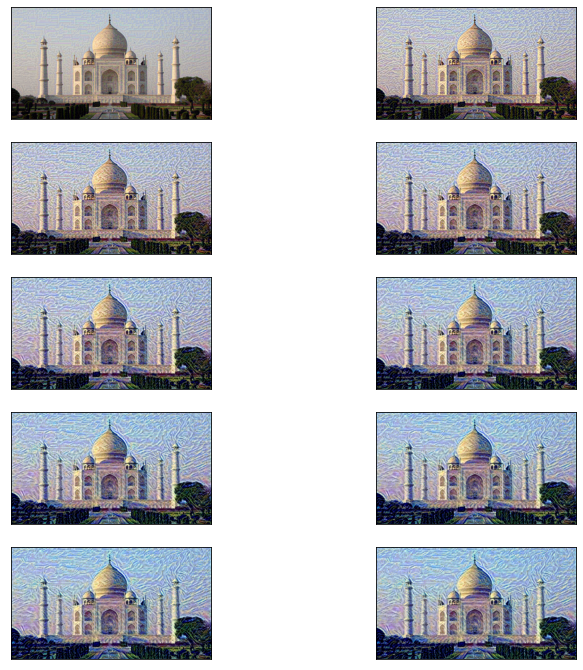

In [81]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

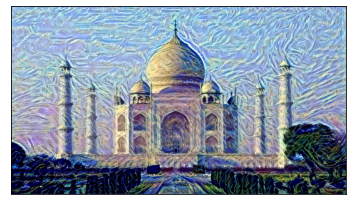

In [82]:
display_image(final)